In [1]:
# ==========================
#  Imports básicos
# ==========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Para modelos clásicos 
import statsmodels.api as sm

# Para ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Opciones de pandas y gráficos
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

print("Librerías cargadas correctamente.")

# Configuración básica
BASE_DIR = r"C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2"

print("Base:", BASE_DIR)

Librerías cargadas correctamente.
Base: C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2


In [2]:
# =========================
#  Carga de datos
# =========================
train = pd.read_csv(r"C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2\data\raw\train.csv", parse_dates=["date"])
test  = pd.read_csv(r"C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2\data\raw\test.csv",  parse_dates=["date"])

print("\nTamaños de los dataframes:")
print("train:", train.shape)
print("test :", test.shape)

print("\nPrimeras filas de train:")
display(train.head())

print("\nPrimeras filas de test:")
display(test.head())


Tamaños de los dataframes:
train: (913000, 4)
test : (45000, 4)

Primeras filas de train:


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10



Primeras filas de test:


,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [3]:
# ==========================
#  Chequeos básicos
# ==========================

print("Tipos de datos en train:")
print(train.dtypes)

print("\nTipos de datos en test:")
print(test.dtypes)

# Valores nulos
print("\nNulos en train:")
print(train.isnull().sum())

print("\nNulos en test:")
print(test.isnull().sum())

# Duplicados
dup_train = train.duplicated(subset=["date", "store", "item"]).sum()
dup_test  = test.duplicated(subset=["id"]).sum()

print(f"\nFilas duplicadas en train (por date-store-item): {dup_train}")
print(f"Filas duplicadas en test (por id): {dup_test}")

# Rango de fechas
print("\nRango de fechas en train:")
print("Mín:", train["date"].min())
print("Máx:", train["date"].max())

print("\nRango de fechas en test:")
print("Mín:", test["date"].min())
print("Máx:", test["date"].max())

# Número de tiendas e ítems
n_stores = train["store"].nunique()
n_items  = train["item"].nunique()
print(f"\nNúmero de tiendas en train: {n_stores}")
print(f"Número de ítems   en train: {n_items}")

Tipos de datos en train:
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

Tipos de datos en test:
id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object

Nulos en train:
date     0
store    0
item     0
sales    0
dtype: int64

Nulos en test:
id       0
date     0
store    0
item     0
dtype: int64

Filas duplicadas en train (por date-store-item): 0
Filas duplicadas en test (por id): 0

Rango de fechas en train:
Mín: 2013-01-01 00:00:00
Máx: 2017-12-31 00:00:00

Rango de fechas en test:
Mín: 2018-01-01 00:00:00
Máx: 2018-03-31 00:00:00

Número de tiendas en train: 10
Número de ítems   en train: 50


## EDA

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64


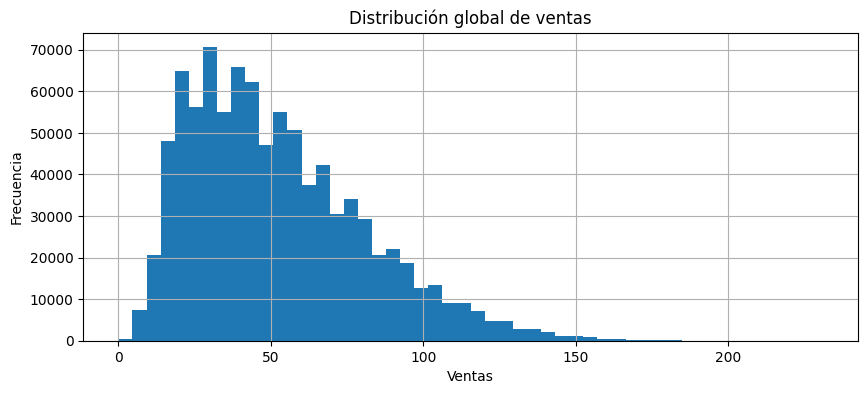

In [12]:
# ==========================
#  Distribución de ventas
# ==========================

print(train["sales"].describe())

plt.figure(figsize=(10,4))
plt.hist(train["sales"], bins=50)
plt.title("Distribución global de ventas")
plt.xlabel("Ventas")
plt.ylabel("Frecuencia")
plt.show()

La distribución global es típica de ventas, con picos alrededor de 30 - 50 unidades y con cola derecha, lo que sugiere alta variabilidad y presencia de ítems con distinta rotación.

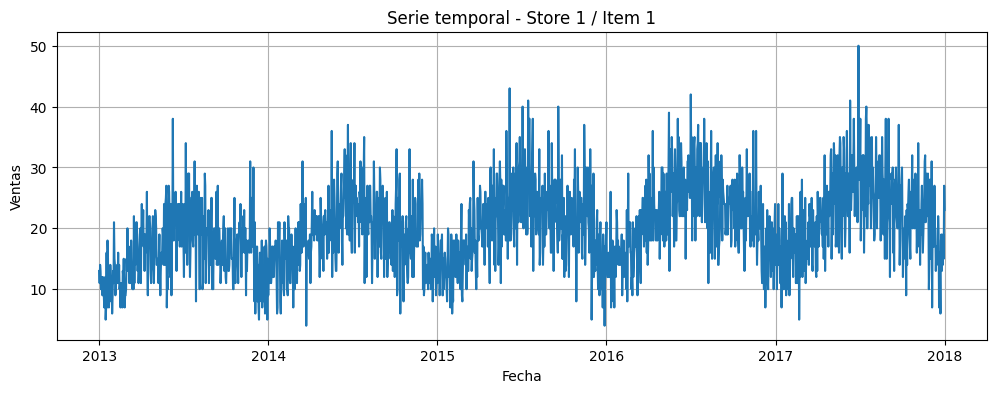

In [5]:
# ==========================
#  Serie simple
# ==========================

serie_1_1 = train[(train["store"] == 1) & (train["item"] == 1)]

plt.figure(figsize=(12,4))
plt.plot(serie_1_1["date"], serie_1_1["sales"])
plt.title("Serie temporal - Store 1 / Item 1")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.grid(True)
plt.show()

La gráfica muestra una fuerte estacionalidad semanal. También variación anual con picos muy visibles en ciertos meses. Se podría considerar la existencia de una tendencia general al alza, y a la vez una suave creciente–decreciente–creciente a lo largo de los años, con bastante ruido. Es una serie claramente no estacionaria.

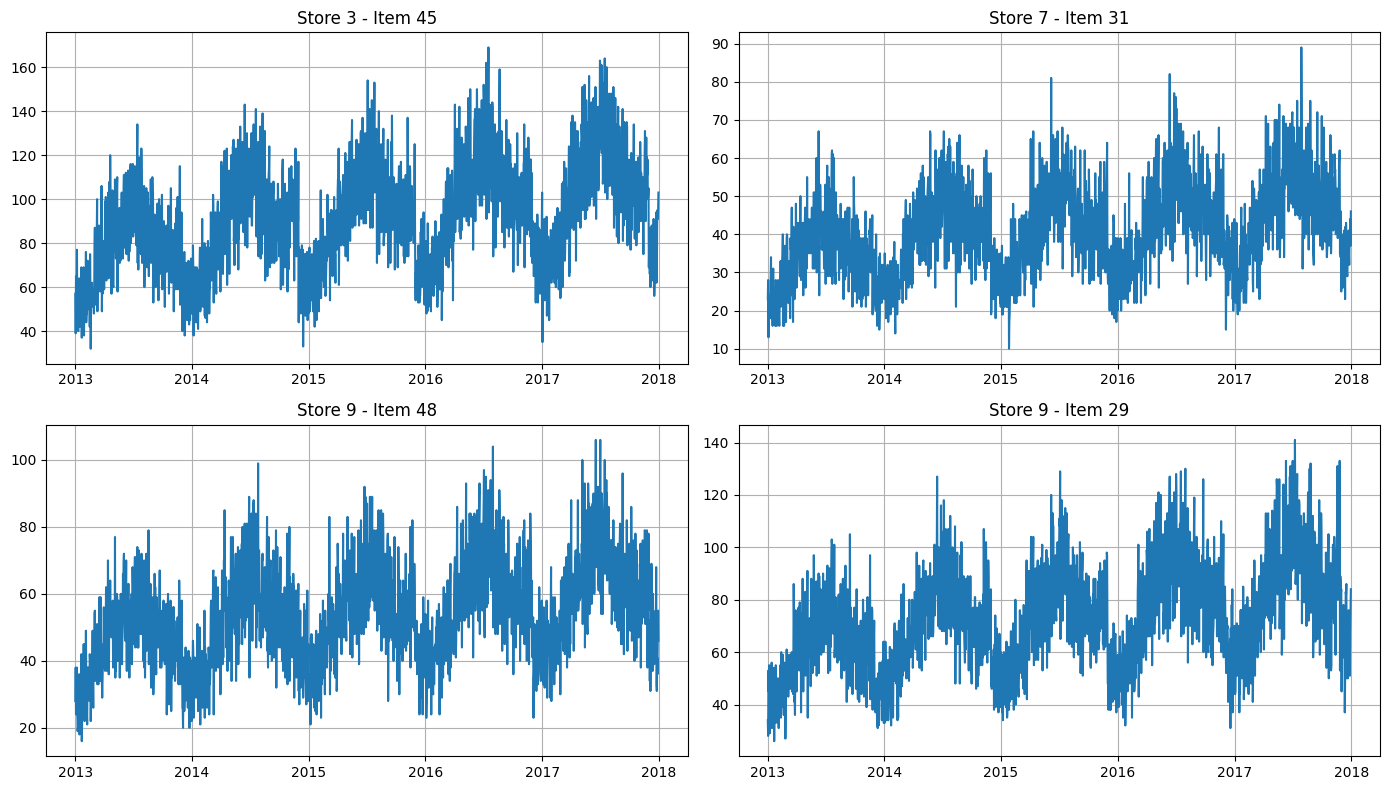

Series graficadas: [(3, 45), (7, 31), (9, 48), (9, 29)]


In [6]:
# ==========================
#  Varias series
# ==========================

import random

muestras = random.sample(
    [(s, i) for s in range(1, 11) for i in range(1, 51)],
    4
)

plt.figure(figsize=(14,8))

for idx, (s, i) in enumerate(muestras, 1):
    temp = train[(train["store"] == s) & (train["item"] == i)]
    plt.subplot(2,2,idx)
    plt.plot(temp["date"], temp["sales"])
    plt.title(f"Store {s} - Item {i}")
    plt.grid(True)

plt.tight_layout()
plt.show()

print("Series graficadas:", muestras)

Al igual que la gráfica anterior, las cuatro series elegidas aleatoriamente muestran variabilidad muy similar a distintos niveles, confirmando la estacionalidad de las ventas.

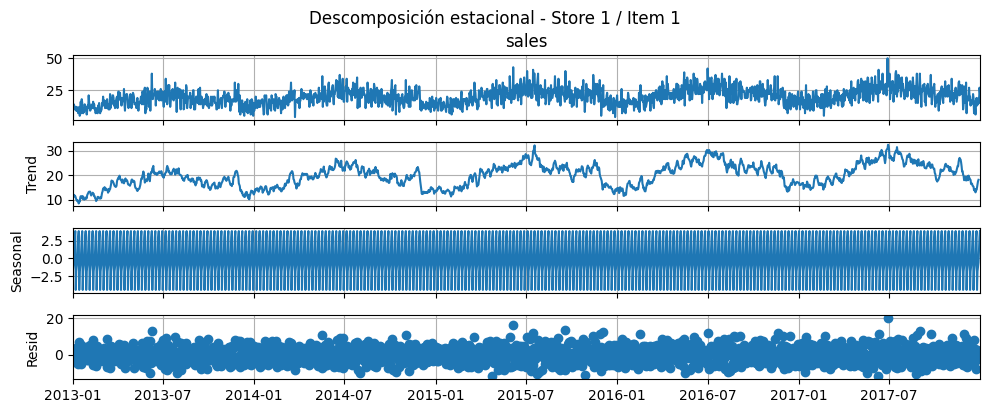

In [7]:
# ==========================
#  Descomposición estacional
# ==========================

from statsmodels.tsa.seasonal import seasonal_decompose

temp = serie_1_1.set_index("date").asfreq("D")  
result = seasonal_decompose(temp["sales"], model="additive", period=7)

result.plot()
plt.suptitle("Descomposición estacional - Store 1 / Item 1", y=1.02)
plt.show()

Hay una tendencia visible aunque irregular. Estacionalidad altamente marcada y periódica, casi perfecta. Residuos con ruido blanco moderado. La estacionalidad es clarísima. a diferentes periodos de tiempo.

<Figure size 1000x400 with 0 Axes>

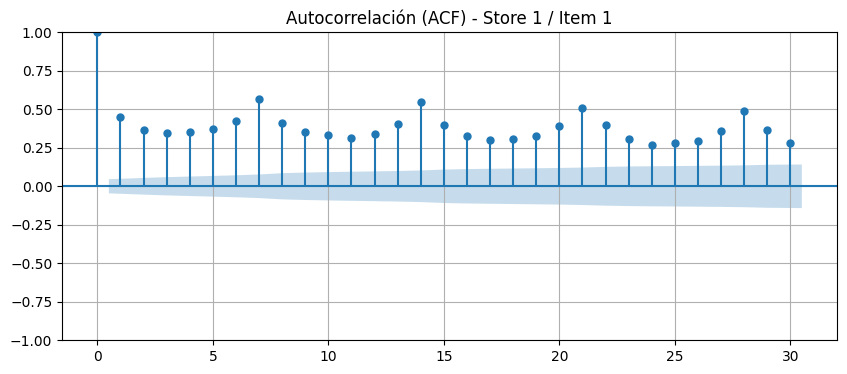

In [8]:
# ==========================
#  ACF
# ==========================

from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,4))
plot_acf(temp["sales"], lags=30)
plt.title("Autocorrelación (ACF) - Store 1 / Item 1")
plt.show()

En la gráfica de la ACF vemos picos enormes en lag 7, 14, 21, 28, lo que confirma estacionalidad semanal (cada 7 días). Esto nos permite justificar:  
- SARIMA con periodo s=7
- Lags relevantes para ML: 1, 7, 14, 21, 28

In [9]:
# ==========================
#  Splits temporales oficiales
# ==========================

from datetime import datetime

splits = {
    "fold1": {
        "train_start": datetime(2013, 1, 1),
        "train_end"  : datetime(2016, 12, 31),
        "valid_start": datetime(2017, 1, 1),
        "valid_end"  : datetime(2017, 3, 31),
    },
    "fold2": {
        "train_start": datetime(2013, 1, 1),
        "train_end"  : datetime(2017, 3, 31),
        "valid_start": datetime(2017, 4, 1),
        "valid_end"  : datetime(2017, 6, 30),
    },
    "fold3": {
        "train_start": datetime(2013, 1, 1),
        "train_end"  : datetime(2017, 6, 30),
        "valid_start": datetime(2017, 7, 1),
        "valid_end"  : datetime(2017, 9, 30),
    },
    "test_interno": {
        "start": datetime(2017, 10, 1),
        "end"  : datetime(2017, 12, 31),
    }
}

# imprimir splits de forma legible
for fold, dates in splits.items():
    print(f"\n{fold}:")
    for key, date in dates.items():
        print(f"  {key}: {date.strftime('%Y-%m-%d')}")


fold1:
  train_start: 2013-01-01
  train_end: 2016-12-31
  valid_start: 2017-01-01
  valid_end: 2017-03-31

fold2:
  train_start: 2013-01-01
  train_end: 2017-03-31
  valid_start: 2017-04-01
  valid_end: 2017-06-30

fold3:
  train_start: 2013-01-01
  train_end: 2017-06-30
  valid_start: 2017-07-01
  valid_end: 2017-09-30

test_interno:
  start: 2017-10-01
  end: 2017-12-31


La razón fundamental detrás de esta estructura de splits es que trabajamos con datos de series de tiempo, y esto cambia por completo la forma en la que hacemos entrenamiento, validación y prueba.  
Para series de tiempo no se puede mezclar o barajar datos, tampoco se puede usar validación cruzada aleatoria (k-fold tradicional). Se debe respetar la dirección del tiempo, y se evalúa el desempeño del modelo simulando cómo sería utilizado en producción.   

- El fold 1, entrena entre 2013 - 2016 y valida en enero - marzo 2017. Evalúa el modelo prediciendo el primer trimestre del año (baja actividad post decembrina, reinicio del ciclo anual).  
- El fold 2, entrena entre 2013 y marzo de 2017 y valida en abril - junio de 2017. Evalúa el desempeño en un trimestre con otra dinámica (estabilidad de mitad de año, menos estacionalidad extrema).  
- El fold 3, entrena entre 2013 y junio de 2017 y valida en julio - septiembre de 2017. Evalúa desempeño en mitad de año, vacaciones de verano (en algunos países), y patrones diferentes en ventas por época.  

En general, buscamos ampliar progresivamente la ventana de entrenamiento y evaluar siempre sobre periodos futuros no usados en el ajuste del modelo. Este esquema respeta la estructura temporal del problema, previene fuga de información y permite analizar la capacidad del modelo para generalizar en distintos contextos temporales.